# PHROG data

PHROG_data must contain:  

phrog revised index: https://storage.googleapis.com/viral_protein_family_plm_embeddings/phrogs/PHROG_index_revised_v4_10292022.csv  

protbert_bfd_embeddings_phrog: download all phrog family embedding pkl objects from google cloud. Follow instructions on repo README.

In [1]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import backend as K
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
import os
from tqdm import tqdm

In [2]:
phrog_data_dir = 'PHROG_data/'

In [3]:
phrog_metadata = pd.read_csv(phrog_data_dir + 'PHROG_index_revised_v4_10292022.csv')

### still only condsider the labels from phrogs v3

In [4]:
phrog_metadata['Category'].value_counts()

unknown function                                     33792
tail                                                  1219
DNA, RNA and nucleotide metabolism                    1065
head and packaging                                     946
other                                                  560
moron, auxiliary metabolic gene and host takeover      458
transcription regulation                               303
lysis                                                  299
connector                                              133
integration and excision                               105
Name: Category, dtype: int64

In [5]:
phrog_known = phrog_metadata[~phrog_metadata['Category'].isna()]
phrog_known = phrog_known[~phrog_known['Category'].isin(['unknown function'])]
len(phrog_known)

5088

In [6]:
cs = set(phrog_known['Category'])

In [7]:
## dict for family:label -> {fl}
## dict for family:vectors -> {fv}
## dict for label:families -> {lf}
fl = {}
fv = {}
lf = {}

for c in cs:
    ps = phrog_known[phrog_known['Category'] == c]['#phrog']
    for p in ps:
        fl[p] = c
        try:
            fv[p] = pickle.load(open('{0}/protbert_bfd_embeddings_phrog/{1}.pkl' ''.format(phrog_data_dir, p), 'rb'))
        except:
            print('{0} embeddings not found' ''.format(p))
            pass
    lf[c] = list(set(ps).intersection(set(fv.keys())))

### building the training and testing splits for PHROG family leave out

In [8]:
train_families = list(set(fv.keys()))

In [9]:
## format training arrays
tr_vectors = [x for f in train_families for x in fv[f]]
tr_vectors = np.vstack(tr_vectors)
tr_label = [[fl[f]] * len(fv[f]) for f in train_families]
tr_label = [j for i in tr_label for j in i]

In [10]:
np.unique(np.array(tr_label), return_counts=True)

(array(['DNA, RNA and nucleotide metabolism', 'connector',
        'head and packaging', 'integration and excision', 'lysis',
        'moron, auxiliary metabolic gene and host takeover', 'other',
        'tail', 'transcription regulation'], dtype='<U49'),
 array([ 98104,  34054,  90584,  16688,  30997,  22566,  37349, 102955,
         39386]))

In [11]:
trainX = tr_vectors
trainY = tr_label

## feed forward neural network

In [12]:
# label binarize
# convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)

In [13]:
# model architechture
model = Sequential()
model.add(Dense(512, input_shape=(1024,), activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(256, input_shape=(512,), activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(128, input_shape=(256,), activation="relu"))
model.add(Dense(9, activation="softmax"))

Metal device set to: Apple M1 Pro


2023-01-10 17:27:45.779257: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-10 17:27:45.779356: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
n_epoch = 20
opt = Adam(0.0001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
H = model.fit(trainX, trainY, epochs=n_epoch, batch_size=60)

Epoch 1/20


2023-01-10 17:27:46.216991: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


   1/7879 [..............................] - ETA: 50:24 - loss: 2.2008 - accuracy: 0.0333

2023-01-10 17:27:46.431950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7879/7879 [==============================] - 66s 8ms/step - loss: 1.2193 - accuracy: 0.5875
Epoch 2/20
7879/7879 [==============================] - 64s 8ms/step - loss: 0.7690 - accuracy: 0.7497
Epoch 3/20
7879/7879 [==============================] - 64s 8ms/step - loss: 0.6270 - accuracy: 0.7984
Epoch 4/20
7879/7879 [==============================] - 64s 8ms/step - loss: 0.5350 - accuracy: 0.8285
Epoch 5/20
7879/7879 [==============================] - 63s 8ms/step - loss: 0.4683 - accuracy: 0.8523
Epoch 6/20
7879/7879 [==============================] - 63s 8ms/step - loss: 0.4173 - accuracy: 0.8696
Epoch 7/20
7879/7879 [==============================] - 63s 8ms/step - loss: 0.3773 - accuracy: 0.8839
Epoch 8/20
7879/7879 [==============================] - 63s 8ms/step - loss: 0.3449 - accuracy: 0.8944
Epoch 9/20
7879/7879 [==============================] - 63s 8ms/step - loss: 0.3173 - accuracy: 0.9040
Epoch 10/20
7879/7879 [==============================] - 63s 8ms/step - loss: 0.2941

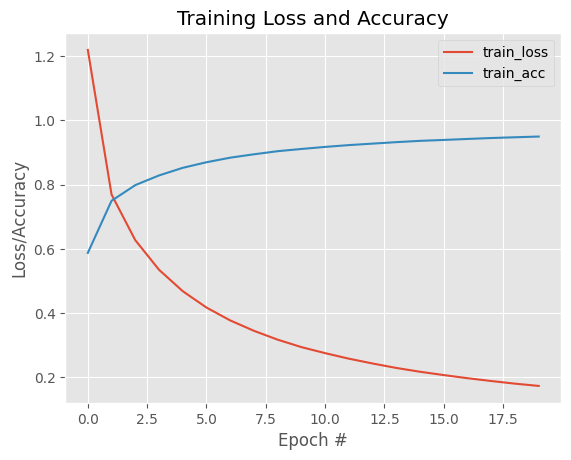

In [15]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, n_epoch), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, n_epoch), H.history["accuracy"], label="train_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()



## test the PHROG unknown protein families

In [16]:
phrog_unknown = phrog_metadata[~phrog_metadata['Category'].isna()]
phrog_unknown = phrog_unknown[phrog_unknown['Category'].isin(['unknown function'])]

In [17]:
ufv = {}
for p in phrog_unknown['#phrog']:
    try:
        ufv[p] = pickle.load(open('{0}/protbert_bfd_embeddings_phrog/{1}.pkl' ''.format(phrog_data_dir,p), 'rb'))
    except:
        print('{0} embeddings not found' ''.format(p))
        pass

In [18]:
confidence = 0.5
confident_unknown = []
unconfident_unknown = []
for f in tqdm(ufv.keys()):
    pred_f = model.predict(ufv[f], verbose=0)
    pred_f = np.mean(pred_f, axis=0)
    if sum(pred_f > confidence) > 0:
        confident_unknown.append(f)
    else:
        unconfident_unknown.append(f)

100%|█████████████████████████████████████| 33792/33792 [15:01<00:00, 37.49it/s]


In [19]:
len(unconfident_unknown)

14280

In [20]:
ufv_vectors = [x for f in unconfident_unknown for x in ufv[f]]
ufv_vectors = np.vstack(ufv_vectors)
ufv_label = ['unknown'] * len(ufv_vectors)

In [21]:
len(ufv_vectors)

187757

### train a new model with an 'unknown' class

In [22]:
vectors = np.concatenate((tr_vectors, ufv_vectors))
label = np.concatenate((tr_label, ufv_label))

In [27]:
trainX = vectors
trainY = label

In [28]:
# label binarize
# convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)

In [29]:
# model architechture
model2 = Sequential()
model2.add(Dense(512, input_shape=(1024,), activation="relu"))
model2.add(Dropout(0.2))
model2.add(Dense(256, input_shape=(512,), activation="relu"))
model2.add(Dropout(0.2))
model2.add(Dense(128, input_shape=(256,), activation="relu"))
model2.add(Dense(10, activation="softmax"))

In [31]:
n_epoch = 20
opt = Adam(0.0001)
model2.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
H2 = model2.fit(trainX, trainY, epochs=n_epoch, batch_size=60)

Epoch 1/20


2023-01-10 18:22:55.030403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11008/11008 [==============================] - 84s 8ms/step - loss: 1.2323 - accuracy: 0.6160
Epoch 2/20
11008/11008 [==============================] - 88s 8ms/step - loss: 0.8818 - accuracy: 0.7318
Epoch 3/20
11008/11008 [==============================] - 80s 7ms/step - loss: 0.7706 - accuracy: 0.7694
Epoch 4/20
11008/11008 [==============================] - 81s 7ms/step - loss: 0.6969 - accuracy: 0.7923
Epoch 5/20
11008/11008 [==============================] - 80s 7ms/step - loss: 0.6408 - accuracy: 0.8099
Epoch 6/20
11008/11008 [==============================] - 80s 7ms/step - loss: 0.5955 - accuracy: 0.8235
Epoch 7/20
11008/11008 [==============================] - 80s 7ms/step - loss: 0.5583 - accuracy: 0.8350
Epoch 8/20
11008/11008 [==============================] - 80s 7ms/step - loss: 0.5266 - accuracy: 0.8445
Epoch 9/20
11008/11008 [==============================] - 80s 7ms/step - loss: 0.4991 - accuracy: 0.8531
Epoch 10/20
11008/11008 [==============================] - 80s 7ms

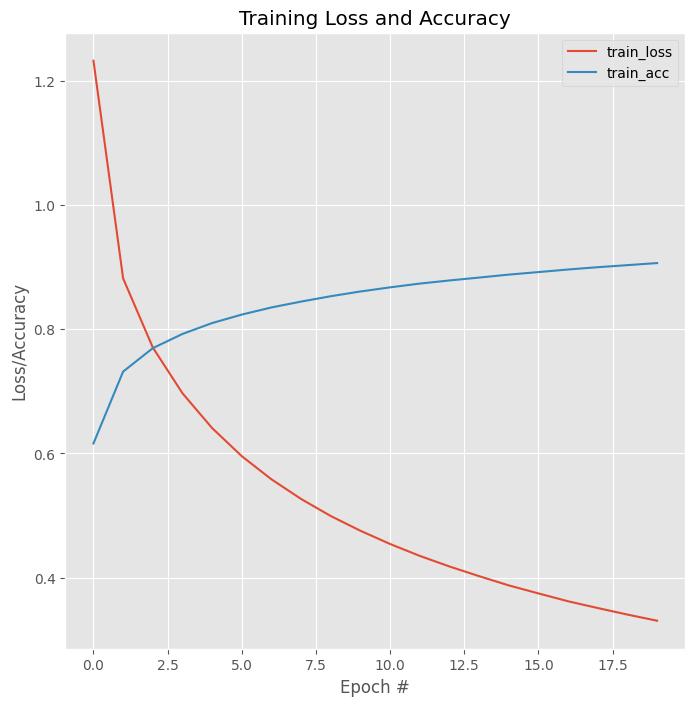

In [33]:
# plot the training loss and accuracy
plt.rcParams["figure.figsize"]=8,8
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, n_epoch), H2.history["loss"], label="train_loss")

plt.plot(np.arange(0, n_epoch), H2.history["accuracy"], label="train_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()



## SAVE MODEL for external testing on protein sequence

In [48]:
os.mkdir('models')
model2.save('models/model_phrog_family_train_ALL_familes_1')
pickle.dump(lb, open('models/model_phrog_family_train_ALL_familes_1_lb.pkl', 'wb'))

INFO:tensorflow:Assets written to: models/model_phrog_family_train_ALL_familes_1/assets
